In [1]:
import pandas as pd
import datetime
import ipywidgets as widgets
import helper_backfill
from IPython.display import Markdown
%matplotlib inline

# A Machine Learning Model for Nowcasting Epidemic Incidence

This notebook is intended to facilitate the use of the model proposed in the paper. All defaults in this notebook reproduce the results of the paper. Two input files are needed:

* `TRAINING DATA FILE` : Data to train the proposed random forest model
* `PREDICTION FILE` : Data that needs to be nowcasted

A sample of both is provided.

## Data loading

#### Modify the following parameters if needed:
* Start date: enter the date you would want the model to start fitting from.
* End date: enter the date you would want the model to fit upto.
* Training data file: specify the data file that contains the data to fit on. Make sure that fitting start and end dates are consistent with this.
* Stability threshold: specify the stability cutoff.
* Prediction file: specify the path of the file that needs to be nowcasted.

In [2]:
style = {'description_width': 'initial'}
start_date = widgets.DatePicker(description='Start date', disabled=False, value = datetime.date(2020, 10, 1))
display(start_date)
end_date = widgets.DatePicker(description='End date', disabled=False, value = datetime.date(2020, 11, 15))
display(end_date)
fit_data = widgets.Dropdown(options=['data_1211', 'data_1222'],value='data_1222',description='Training data file:',disabled=False, style=style)
display(fit_data)
threshold = widgets.FloatSlider( value=0.05, min=0, max=1, step=0.05, description='Stability threshold:', disabled=False, continuous_update=False, orientation='horizontal', readout=True, style=style )
display(threshold)
prediction_data = widgets.Text(value='COVIDSummaryData12112020.csv',description='Prediction file:',disabled=False, style=style)
display(prediction_data)

DatePicker(value=datetime.date(2020, 10, 1), description='Start date')

DatePicker(value=datetime.date(2020, 11, 15), description='End date')

Dropdown(description='Training data file:', index=1, options=('data_1211', 'data_1222'), style=DescriptionStyl…

FloatSlider(value=0.05, continuous_update=False, description='Stability threshold:', max=1.0, step=0.05, style…

Text(value='COVIDSummaryData12112020.csv', description='Prediction file:', style=DescriptionStyle(description_…

In [3]:
#initializing parameters based on input data
FIT_START = helper_backfill.datetime_str(start_date)#'2020-10-01'
FIT_END = helper_backfill.datetime_str(end_date)
FIT_DATA = f'{fit_data.value}.csv'#'mostrecent_data.csv'
THRESH = threshold.value
PREDICT_DATA = prediction_data.value

FIT_START = pd.to_datetime(FIT_START)
FIT_END = pd.to_datetime(FIT_END)

#loading fit data
main_df = pd.read_csv(FIT_DATA)
subset_df = helper_backfill.load_extract_data(main_df, FIT_START, FIT_END)

#loading data to be nowcasted
agg_pred_data = helper_backfill.load_nowcast_data(PREDICT_DATA)

## Preliminary data visualization

### Cases in Ohio

This plot shows daywise COVID-19 cases in Ohio State on a given day. The shaded area shows preliminary case data which is likely under-reported.

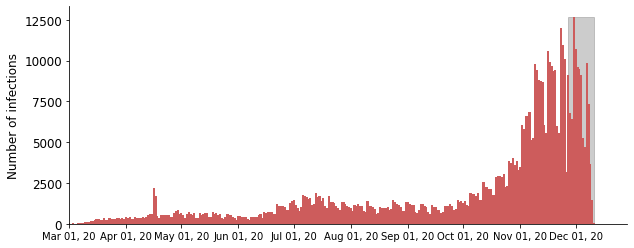

In [4]:
helper_backfill.plot_total_case_hist(agg_pred_data)

### Progression of infection count

Progression of infection count $(I_{tD})$ for a specific day $(D)$ value over a time range $(t)$. There is a steep rise in the infection count in the initial days of data collection as the data is backfilled, but it gradually stabilizes.

#### Specify the date to plot the day trend for:

In [5]:
in_date = widgets.DatePicker(description='Date', disabled=False, value = datetime.date(2020, 11, 1))
display(in_date)

DatePicker(value=datetime.date(2020, 11, 1), description='Date')

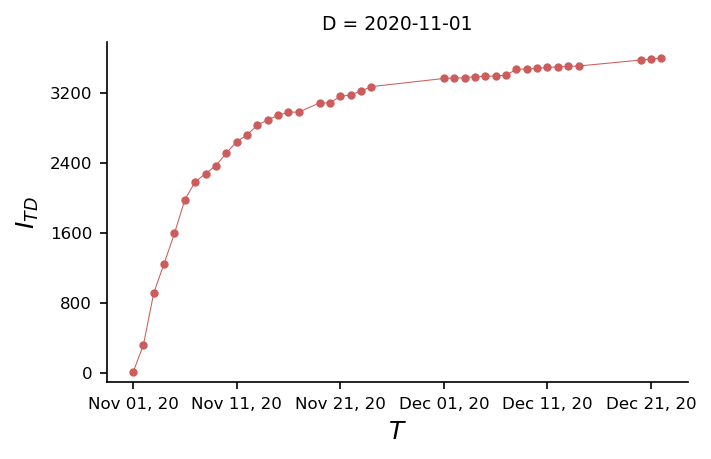

In [6]:
helper_backfill.plot_day_trend(helper_backfill.datetime_str(in_date), main_df)

## Model training

This section trains the model for prediction and then visualizes the predictions to check the quality of fits.

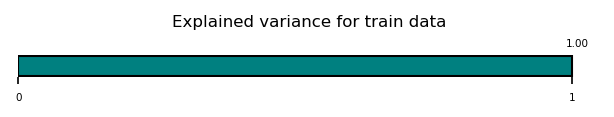

In [7]:
#model training
clf = helper_backfill.fit_random_forest(subset_df, THRESH)

### Quality of fit

Actual versus predicted of missing fraction of number of cases.

#### Please enter the end date for test dataset

This is the end of date range and the model will be evaluated between `FIT_END` and the specified date. Please make sure that specified date is contained in the `FIT_DATA`.

In [8]:
test_end_date = widgets.DatePicker(description='End date' , disabled=False, value = datetime.date(2020, 12, 22), style = style)
print ('End date should be after ' +str(FIT_END)[:-8])
display(test_end_date)

End date should be after 2020-11-15 


DatePicker(value=datetime.date(2020, 12, 22), description='End date', style=DescriptionStyle(description_width…

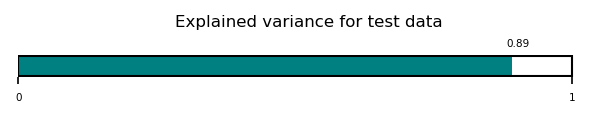

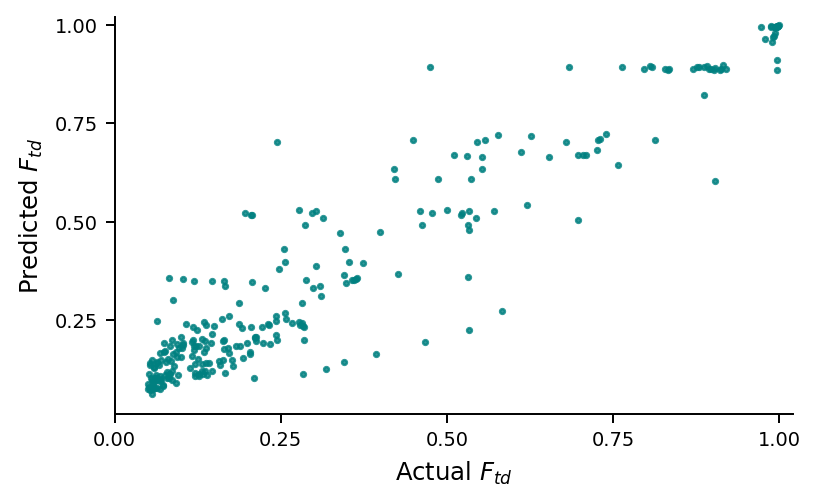

In [9]:
#to visualize the actual vs predicted data
score, y_train, pred, features = helper_backfill.make_prediction(clf, main_df, FIT_END, test_end_date.value, THRESH)
helper_backfill.plot_explained_bar(score, 'test')
helper_backfill.plot_actual_predicted(y_train, pred)

### Prediction of missing fraction

Visualization of missing fraction $(F_{td})$ predicted at various values of days since data collection $(\Delta)$

#### Please enter the maximum value of days $(\Delta)$ for which missing fraction is to be plotted.

In [10]:
days_to_plot =  widgets.Dropdown(options=[str(i) for i in range(1,15)],value='14',description='Number of days to plot',disabled=False,style=style)
display(days_to_plot)

Dropdown(description='Number of days to plot', index=13, options=('1', '2', '3', '4', '5', '6', '7', '8', '9',…

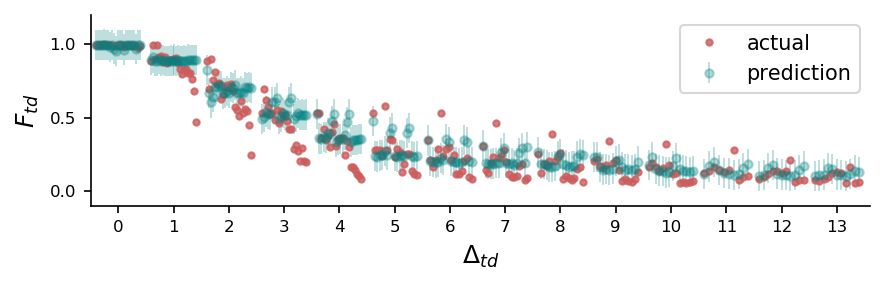

In [11]:
#to visualize predicted missingness as a function of days since data collection
helper_backfill.days_since_vs_missingness(pred, y_train, features, int(days_to_plot.value))

### Prediction of infection count

Visualization of infection count predicted (using $F_{td}$) for a given day.

#### Please enter the day for which infection count is to be plotted

In [12]:
corrected_trend_date = widgets.DatePicker(description='Date', disabled=False, value = datetime.date(2020, 11, 20))
display(corrected_trend_date)

DatePicker(value=datetime.date(2020, 11, 20), description='Date')

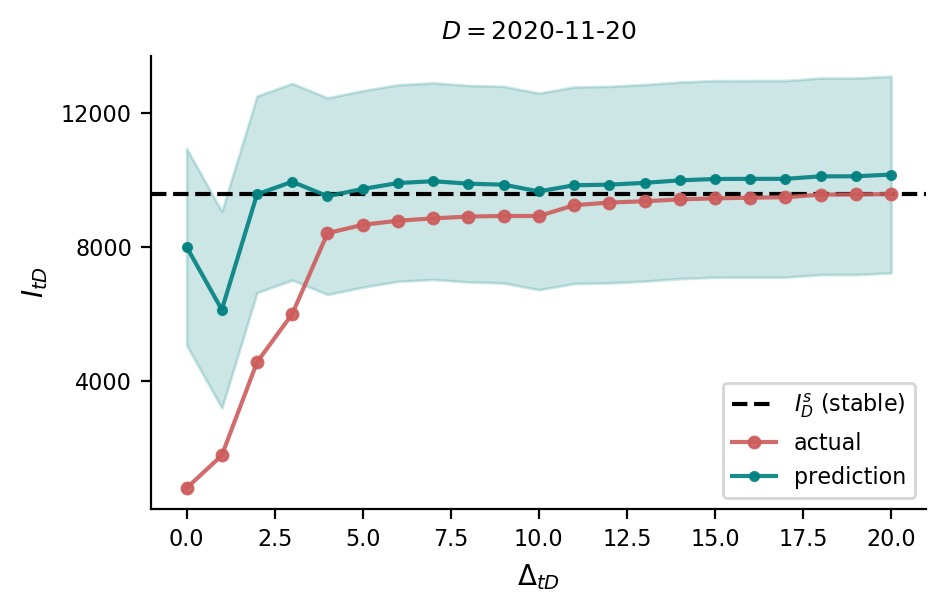

In [13]:
helper_backfill.plot_sample_corrected_day(helper_backfill.datetime_str(corrected_trend_date), main_df, clf, THRESH)

## Nowcasting the infections using random forest model

In this section, the random forest model is used to make predictions on the daily data from ODH and generate a downloadable csv file. The range of nowcasting starts from the latest date in the data and goes upto the days specified below. A plot showing the predictions and the actual values is also displayed.

#### How many days would you like the data to be backfilled?

In [14]:
num_backfilled_input = widgets.IntText(value=10,description='Days to nowcast:',disabled=False, style=style)
display(num_backfilled_input)

IntText(value=10, description='Days to nowcast:', style=DescriptionStyle(description_width='initial'))

Data from 2020-12-01 to 2020-12-11 has been nowcasted.

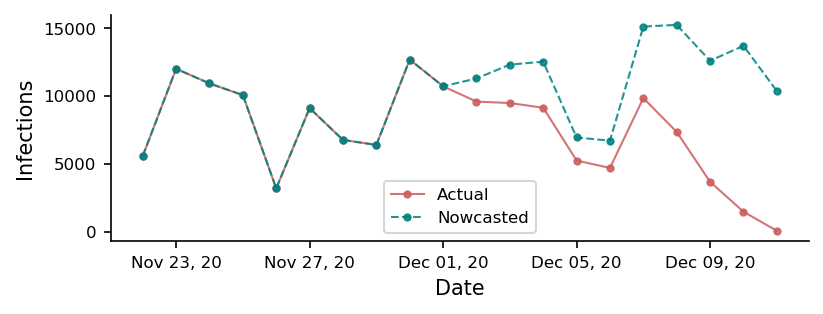

In [15]:
display(Markdown(f'Data from {agg_pred_data.index[-1].date()- datetime.timedelta(days=num_backfilled_input.value)} to {agg_pred_data.index[-1].date()} has been nowcasted.'))
nowcast_data = helper_backfill.backfill_data(num_backfilled_input.value, agg_pred_data, clf)
helper_backfill.plot_backfilled_actual( agg_pred_data, nowcast_data, num_backfilled_input.value)

Run the following cell to save the nowcast data file (saved in the same folder as the notebook).

In [16]:
nowcast_data.to_csv("nowcast_data.csv")